---
* ### Import as libs  
---

In [34]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
from carima import generate_matrices, get_G, get_F
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter, MaxNLocator
from matplotlib.animation import FuncAnimation, PillowWriter

---
* ### Função para plotar, printar TF e matriz
---

In [35]:
def plot(time, y_matriz, title, cols_name, time_aux=None, y_matriz_aux=None, plot=False, yticks_min0max=False, xticks_min0max=False):
    """
    Plota gráficos em grade (n_row x n_col) com estilo mais profissional,
    preservando 100% a lógica original de offsets, step/plot e legendas.
    """
    n_row, n_col = len(y_matriz), len(y_matriz[0])

    # altura = 1 * n_row
    altura = n_row * 1.12

    with plt.rc_context({
        "font.size": 9,
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "figure.constrained_layout.use": False
    }):
        fig, axs = plt.subplots(n_row, n_col, figsize=(11, altura), sharex=True, constrained_layout=True)

        if n_row == 1 and n_col == 1:
            axs = [[axs]]
        elif n_row == 1:
            axs = [axs]
        elif n_col == 1:
            axs = [[ax] for ax in axs]

        for j in range(n_col):
            axs[0][j].set_title(f'{title} - {cols_name[j]}')

        main_lw = 1.1
        aux_lw = 1.0
        msize = 3

        # encontra o valor de y máximo para ajustar todos os eixos 
        y_max, y_min = -np.inf, np.inf
        for i in range(n_row):
            for j in range(n_col):
                dic = y_matriz[i][j]
                y_data = dic[0]
                y_max = max(y_max, np.max(y_data))
                y_min = min(y_min, np.min(y_data))
                if y_matriz_aux is not None:
                    dic_aux = y_matriz_aux[i][j]
                    y_data_aux = dic_aux[0]
                    y_max = max(y_max, np.max(y_data_aux))
                    y_min = min(y_min, np.min(y_data_aux))

        for i in range(n_row):
            for j in range(n_col):
                ax = axs[i][j]
                ax.set_axisbelow(True)  
                ax.grid(True, which='major', linestyle=':', alpha=0.5)
                ax.xaxis.set_minor_locator(AutoMinorLocator())
                ax.yaxis.set_minor_locator(AutoMinorLocator())
                ax.grid(True, which='minor', linestyle=':', alpha=0.3, linewidth=0.5)
                ax.margins(y=0.1) 
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                ax.yaxis.set_major_locator(MaxNLocator(nbins='auto', prune=None))
                #ymin, ymax = ax.get_ylim()
                ax.set_ylim(y_min * 1.1, y_max * 1.1)

                for side in ["top", "right", "left", "bottom"]:
                    ax.spines[side].set_linewidth(0.8)
                    ax.spines[side].set_alpha(0.6)

                offset_x = 0
                if y_matriz_aux is not None and time_aux is not None:
                    dic_aux = y_matriz_aux[i][j]
                    offset_x = len(dic_aux[0])
                    if plot:
                        ax.plot(
                            time_aux[:offset_x], dic_aux[0],
                            label=dic_aux[1], color=dic_aux[2], marker=dic_aux[3],
                            linewidth=aux_lw, markersize=msize, alpha=0.95
                        )
                    else:
                        ax.step(
                            time_aux[:offset_x], dic_aux[0],
                            label=dic_aux[1], color=dic_aux[2], marker=dic_aux[3],
                            linewidth=aux_lw, where='pre'
                        )

                    # transforma em dt
                    dt = time[1] - time[0]
                    offset_x = offset_x * dt

                # plota as linhas principais
                dic = y_matriz[i][j]
                if plot:
                    ax.plot(
                        time + offset_x, dic[0],
                        label=dic[1], color=dic[2], marker=dic[3],
                        linewidth=main_lw, markersize=msize, alpha=0.98
                    )
                else:
                    ax.step(
                        time + offset_x, dic[0],
                        label=dic[1], color=dic[2], marker=dic[3],
                        linewidth=main_lw, where='pre'
                    )

                leg = ax.legend(loc='upper right', frameon=True, framealpha=0.85,
                                handlelength=1.8, borderaxespad=0.6)
                leg.get_frame().set_linewidth(0.6)
                leg.get_frame().set_alpha(0.9)

        plt.tight_layout(pad=1.2)
        plt.show()

def print_tf(sys):
    # printa só as ultimas 3 linhas 
    text = sys.__str__().splitlines()
    for line in text[-3:]:
        print(line)

# Converter cada canal SymPy -> control.TransferFunction SISO (em s)
def sympy_to_tf(expr_s, s_symbol):
    """Converte uma função racional em s (SymPy) -> control.TransferFunction SISO."""
    num, den = sp.fraction(sp.together(sp.simplify(expr_s)))
    num_poly = sp.Poly(num, s_symbol)
    den_poly = sp.Poly(den, s_symbol)

    # Coeficientes do maior para o menor grau
    num_cf = [float(c) for c in num_poly.all_coeffs()]
    den_cf = [float(c) for c in den_poly.all_coeffs()]
    return ctl.tf(num_cf, den_cf)

def print_matriz(mat):
    sp.pprint(mat)
    print()

In [36]:
def plot_ladder_uq(time, y_matriz, col_name=("u","q"), x_label="Deslocamento"):
    
    n_row = len(y_matriz)
    n_col = len(y_matriz[0])

    def extract_col(j):
        series = []
        for i in range(n_row):
            dic = y_matriz[i][j]
            y = np.asarray(dic[0])
            label = str(dic[1]) if len(dic) > 1 else f"S{i}"
            color = dic[2] if len(dic) > 2 else None
            marker = dic[3] if len(dic) > 3 else 'o'
            series.append((y, label, color, marker))
        return series
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 6), constrained_layout=True, sharey=True)

    with plt.rc_context({
            "font.size": 9,
            "axes.titlesize": 11,
            "axes.labelsize": 10,
            "legend.fontsize": 8,
            "xtick.labelsize": 9,
            "ytick.labelsize": 9,
            "axes.linewidth": 0.8,
            "grid.linewidth": 0.6,
            "axes.autolimit_mode": "round_numbers",
        }):

        # setup do único eixo
        ax.set_axisbelow(True)
        ax.grid(True, which='major', linestyle=':', alpha=0.5)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.grid(True, which='minor', linestyle=':', alpha=0.3, linewidth=0.5)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        # posições y uniformes + rótulos x1..xn
        y_pos = np.arange(1, n_row + 1)
        ax.set_ylim(y_pos[0] - 0.5, y_pos[-1] + 0.5)
        ax.set_yticks(y_pos, [f"x{i}" for i in range(1, n_row + 1)])
        ax.set_xlabel(x_label)

        palette = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5','C6','C7'])
        
        all_vals = []

        handles = []
        for col in range(n_col):
            series = extract_col(col)
            color = palette[col % len(palette)]
            x_max = np.array([float(np.max(s[0])) for s in series])
            all_vals.append(x_max)

            (line_handle,) = ax.plot(x_max, y_pos, linewidth=1.2, alpha=0.9, color=color, label=str(col_name[col]) if col < len(col_name) else f"col {col}")
            for i, (y, label, color_unused, marker) in enumerate(series):
                ax.plot([x_max[i]], [y_pos[i]],
                        linestyle='None',
                        marker=marker or 'o',
                        markersize=7.5,
                        markerfacecolor='none',
                        markeredgewidth=1.2,
                        color=color)
            handles.append(line_handle)

        all_vals = np.abs(np.concatenate(all_vals)) if len(all_vals) else np.array([0.0])
        Xmax = float(all_vals.max()) if all_vals.size else 0.0
        Xpad = 1.08 * (Xmax if Xmax > 0 else 1.0)
        ax.set_xlim(0, Xpad)

        ax.legend(handles=handles, loc='lower right')

    plt.tight_layout()
    plt.show()


In [37]:
def plot_ladder_uq_gif(time, y_matriz, col_name=("u","q"), x_label="Deslocamento"):
    
    n_row = len(y_matriz)
    n_col = len(y_matriz[0])

    def extract_col(j):
        series = []
        for i in range(n_row):
            dic = y_matriz[i][j]
            y = np.asarray(dic[0])
            label = str(dic[1]) if len(dic) > 1 else f"S{i}"
            color = dic[2] if len(dic) > 2 else None
            marker = dic[3] if len(dic) > 3 else 'o'
            series.append((y, label, color, marker))
        return series

    fig, ax = plt.subplots(1, 1, figsize=(3, 6), constrained_layout=True, sharey=True)

    with plt.rc_context({
            "font.size": 9,
            "axes.titlesize": 11,
            "axes.labelsize": 10,
            "legend.fontsize": 8,
            "xtick.labelsize": 9,
            "ytick.labelsize": 9,
            "axes.linewidth": 0.8,
            "grid.linewidth": 0.6,
            "axes.autolimit_mode": "round_numbers",
        }):

        ax.set_axisbelow(True)
        ax.grid(True, which='major', linestyle=':', alpha=0.5)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.grid(True, which='minor', linestyle=':', alpha=0.3, linewidth=0.5)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        y_pos = np.arange(1, n_row + 1)
        ax.set_ylim(y_pos[0] - 0.5, y_pos[-1] + 0.5)
        ax.set_yticks(y_pos, [f"x{i}" for i in range(1, n_row + 1)])
        ax.set_xlabel(x_label)

        palette = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5','C6','C7'])
        
        all_vals = []
        series_per_col = []
        for col in range(n_col):
            series = extract_col(col)
            series_per_col.append(series)
            col_vals = np.concatenate([np.asarray(s[0]).ravel() for s in series])
            all_vals.append(np.abs(col_vals))

        all_vals = np.concatenate(all_vals) if len(all_vals) else np.array([0.0])
        Xmax = float(all_vals.max()) if all_vals.size else 0.0
        Xpad = 1.08 * (Xmax if Xmax > 0 else 1.0)
        ax.set_xlim(-Xpad, Xpad)

        handles = []
        dyn_lines = []
        dyn_points = []
        for col in range(n_col):
            series = series_per_col[col]
            color = palette[col % len(palette)]
            label_col = str(col_name[col]) if col < len(col_name) else f"col {col}"

            x_now = np.array([float(s[0][0]) for s in series])

            (line_handle,) = ax.plot(x_now, y_pos, linewidth=1.2, alpha=0.9, color=color, label=label_col)
            pts = []
            for i, (y, label, color_unused, marker) in enumerate(series):
                h = ax.plot([x_now[i]], [y_pos[i]],
                            linestyle='None',
                            marker=marker or 'o',
                            markersize=7.5,
                            markerfacecolor='none',
                            markeredgewidth=1.2,
                            color=color)[0]
                pts.append(h)

            handles.append(line_handle)
            dyn_lines.append(line_handle)
            dyn_points.append(pts)

        ax.legend(handles=handles, loc='lower right')

        T = len(np.asarray(time))
        frames_idx = np.arange(1, T + 1, dtype=int)

        def update(k):
            artists = []
            for col in range(n_col):
                series = series_per_col[col]
                x_now = np.array([float(s[0][k-1]) for s in series])
                dyn_lines[col].set_data(x_now, y_pos)
                artists.append(dyn_lines[col])
                for i, h in enumerate(dyn_points[col]):
                    h.set_data([x_now[i]], [y_pos[i]])
                    artists.append(h)
            return artists

        anim = FuncAnimation(fig, update, frames=frames_idx, blit=True, interval=1000/15)
        anim.save("ladder_uq.gif", writer=PillowWriter(fps=15))

    print("Animação salva como 'ladder_uq.gif'.")
    plt.close()

---
* ### Constantes
---

In [38]:
import numpy as np

# -----------------------------
#       Dados do artigo (adicionei um k e c para o ATMD senao ele vai pro infinito)
# -----------------------------

n_node = 6
m_ton  = np.array([2.16, 2.34, 2.25, 2.18, 2.56, 2.52, 1.175])      # [t]
k_kN_m = np.array([555, 504, 407, 316, 221, 102, 90])               # [kN/m]
c_kNs_m= np.array([3.26, 8.20, 4.72, 4.16, 3.18, 1.54, 1.00])       # [kNs/m]
m_amd_ton = 0.175                                                   # [t]

# Ajustei o ganho só pra plotar
ton_to_kg   = 1e-3
kN_to_N     = 1e-3
kNs_to_Ns   = 1e-3

m_arr  = (m_ton * ton_to_kg).tolist()
k_arr = (k_kN_m * kN_to_N).tolist()
c_arr = (c_kNs_m * kNs_to_Ns).tolist()

'''n_node = 6

# massas
coef_m = 0.5
ATMD_m = 2.5
m_arr = [i*coef_m if i < n_node+1 else ATMD_m for i in range(1, n_node+2)]

coef_k = 1.0
ATMD_k = 0.5
k_arr = [i*coef_k if i < n_node+1 else ATMD_k for i in range(1, n_node+2)]

u_idx_list = [4, 5]        
k_arr = [ (2.0*k if (idx+1) in u_idx_list else k)
          for idx, k in enumerate(k_arr) ]

zeta_star = 0.7
import math
c_arr = [ 2.0*zeta_star*math.sqrt(k*m) for k, m in zip(k_arr, m_arr) ]'''

beta_0 = 0.0033


---
* ### Matrizes
---

In [39]:
# ATMD variaveis 
c_and_coef = True
offset = 1 if c_and_coef else 2

# Matriz de massa
m_matriz = sp.diag(*m_arr)

# Matriz de amortecimento
c_arr_desl = [c_arr[i] + c_arr[i+1] if i < len(c_arr) - 1 else c_arr[i] for i in range(len(c_arr))]
c_matriz = sp.diag(*c_arr_desl)
for i in range(len(c_arr) - offset):
    c_matriz[i, i+1] = -c_arr[i+1]
    c_matriz[i+1, i] = -c_arr[i+1]

# Matriz de rigidez
k_arr_desl = [k_arr[i] + k_arr[i+1] if i < len(k_arr) - 1 else k_arr[i] for i in range(len(k_arr))]
k_matriz = sp.diag(*k_arr_desl)
for i in range(len(k_arr) - offset):
    k_matriz[i, i+1] = -k_arr[i+1]
    k_matriz[i+1, i] = -k_arr[i+1]

# Matriz da entrada u [0 0 0 ... -1 1].T 
B = sp.Matrix([[0] for _ in range(n_node - 1)] + [[-1], [1]])

# Matriz de perturbação
C = sp.Matrix([[0] for _ in range(n_node - 1)] + [[0.5], [0]])

---
* ### Funções de transferência
---

In [40]:
t, s = sp.symbols('t s', positive=True, real=True)

# M*x'' + N*x' + K*x = B*u + C*q
# (M*s**2 + N*s + K)*X = B*U + C*Q
# AX = BU + CQ
A = m_matriz*s**2 + c_matriz*s + k_matriz

# Função de transferência do sistema
H_U = A.inv() * B
H_Q = A.inv() * C

# Simplificação das expressões
H_U = sp.simplify(H_U)
H_Q = sp.simplify(H_Q)

# matriz de transferência do sistema 
H = sp.Matrix.hstack(H_U, H_Q)

---
* ### Matriz de TF - sistema continuo
---

In [41]:
H_s_matriz = [[] for _ in range(H.rows)]
for i in range(H.rows):
    for j in range(H.cols):
        H_s_matriz[i].append(sympy_to_tf(H[i,j], s))

for hi in H_s_matriz:
    for hj in hi:
        print_tf(hj)
        print()

                                                                         -9.265e-16 s^7 - 3.33e-13 s^6 - 4.769e-11 s^5 - 3.404e-09 s^4 - 1.211e-07 s^3 - 1.717e-06 s^2
  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  1.879e-19 s^14 + 4.105e-18 s^13 + 3.563e-16 s^12 + 5.227e-15 s^11 + 2.31e-13 s^10 + 2.268e-12 s^9 + 6.649e-11 s^8 + 4.212e-10 s^7 + 9.074e-09 s^6 + 3.393e-08 s^5 + 5.681e-07 s^4 + 1.008e-06 s^3 + 1.365e-05 s^2 + 6.387e-06 s + 7.299e-05

                                                            4.632e-16 s^7 + 1.669e-13 s^6 + 2.402e-11 s^5 + 1.735e-09 s^4 + 6.381e-08 s^3 + 1.04e-06 s^2 + 5.367e-06 s + 6.575e-05
  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

---
* ### Matriz de TF - sistema discreto
---

In [42]:
# tempo de amostragem 
T = 1.75

H_z_matriz = [[] for _ in range(H.rows)]

# converter cada canal para TF discreto
for i in range(H.rows):
    for j in range(H.cols):
        H_z_matriz[i].append(ctl.sample_system(H_s_matriz[i][j], T, method="zoh"))

# print
for hi in H_z_matriz:
    for hj in hi:
        print_tf(hj)
        print()

     -0.2867 z^13 + 0.341 z^12 - 0.4029 z^11 + 0.2995 z^10 - 0.01713 z^9 + 0.07526 z^8 - 0.000481 z^7 - 0.00779 z^6 - 0.0006485 z^5 - 9.908e-06 z^4 + 8.868e-08 z^3 - 6.254e-10 z^2 + 1.033e-13 z - 1.634e-17
  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  z^14 - 0.2961 z^13 + 1.312 z^12 - 0.2376 z^11 + 0.3984 z^10 - 0.01422 z^9 + 0.01706 z^8 + 0.004799 z^7 + 0.001963 z^6 + 0.0001899 z^5 + 4.029e-06 z^4 - 5.934e-08 z^3 + 3.772e-10 z^2 + 5.61e-14 z + 2.505e-17

    0.9202 z^13 + 0.5992 z^12 + 0.1625 z^11 + 0.2543 z^10 + 0.02269 z^9 + 0.002435 z^8 + 0.005157 z^7 + 0.00334 z^6 + 0.0002701 z^5 + 4.383e-06 z^4 - 3.997e-08 z^3 + 2.782e-10 z^2 - 4.642e-14 z + 7.371e-18
  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------

---
* ### Plot - resposta ao impulso
---

In [43]:
# dados pra simular
start = 0
stop = 150
step = T
step_continuo = 0.01
time = np.arange(start, stop, step)
time_continuo = np.arange(start, stop, step_continuo)

cols_name = ['u', 'q']

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_11168\2297086692.py:111: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


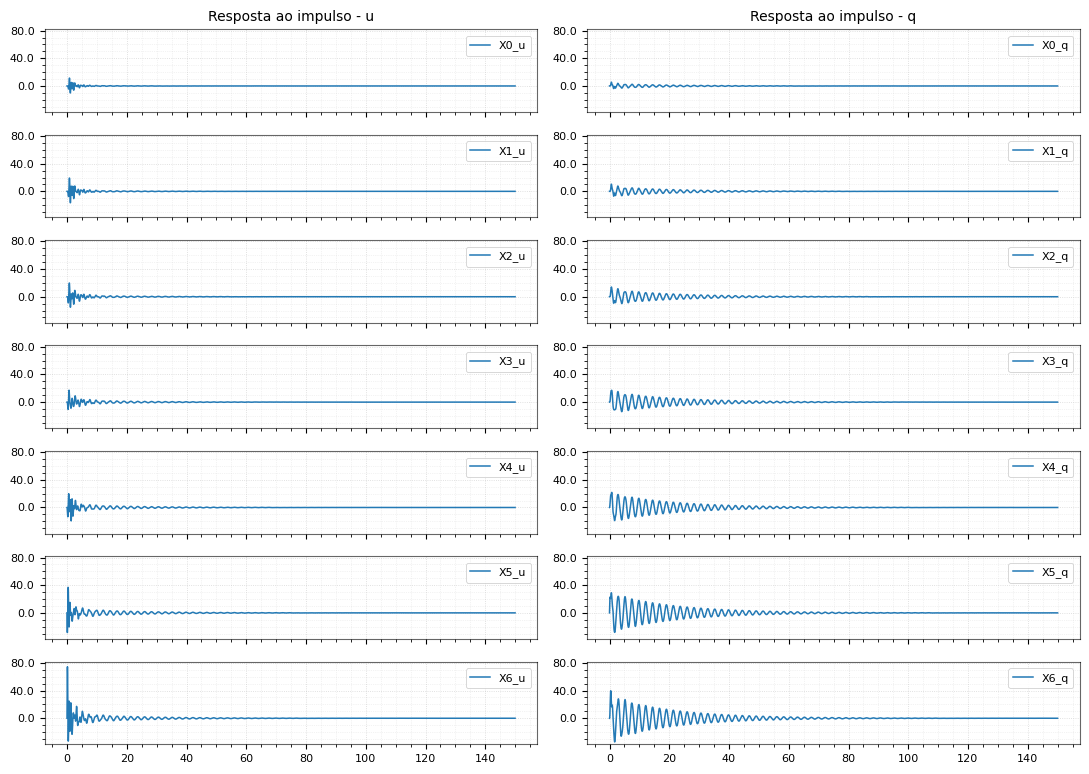

In [44]:
# plot a resposta ao impulso
y_matriz_out = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        t_out, y_out = ctl.impulse_response(H_s_matriz[i][j], T=time_continuo)
        y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_matriz_out[i].append(y_plot)

# plot 
plot(time_continuo, y_matriz_out, "Resposta ao impulso", cols_name, plot=True)

---
* ### Plot - resposta ao impulso
---

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_11168\2297086692.py:111: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


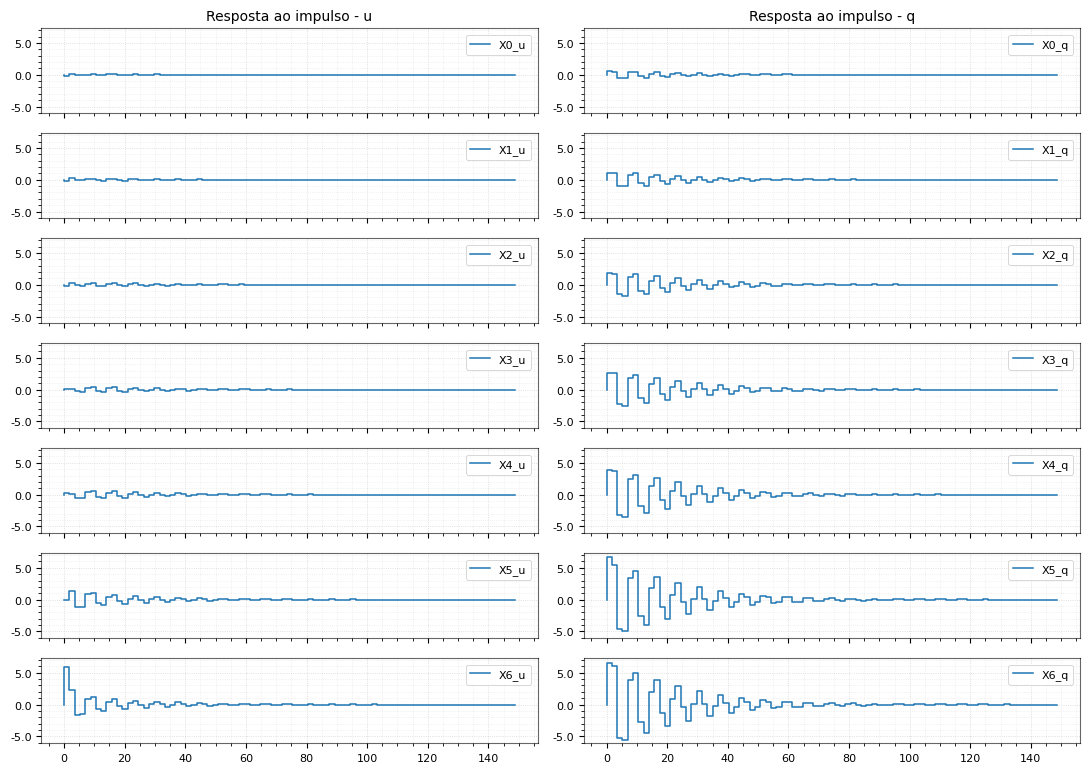

In [45]:
# plot a resposta ao impulso
y_matriz_out = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        t_out, y_out = ctl.impulse_response(H_z_matriz[i][j], T=time)
        y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_matriz_out[i].append(y_plot)

# plot 
plot(time, y_matriz_out, "Resposta ao impulso", cols_name)

---
* ### Predição - usando CARIMA
---

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_11168\2297086692.py:111: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


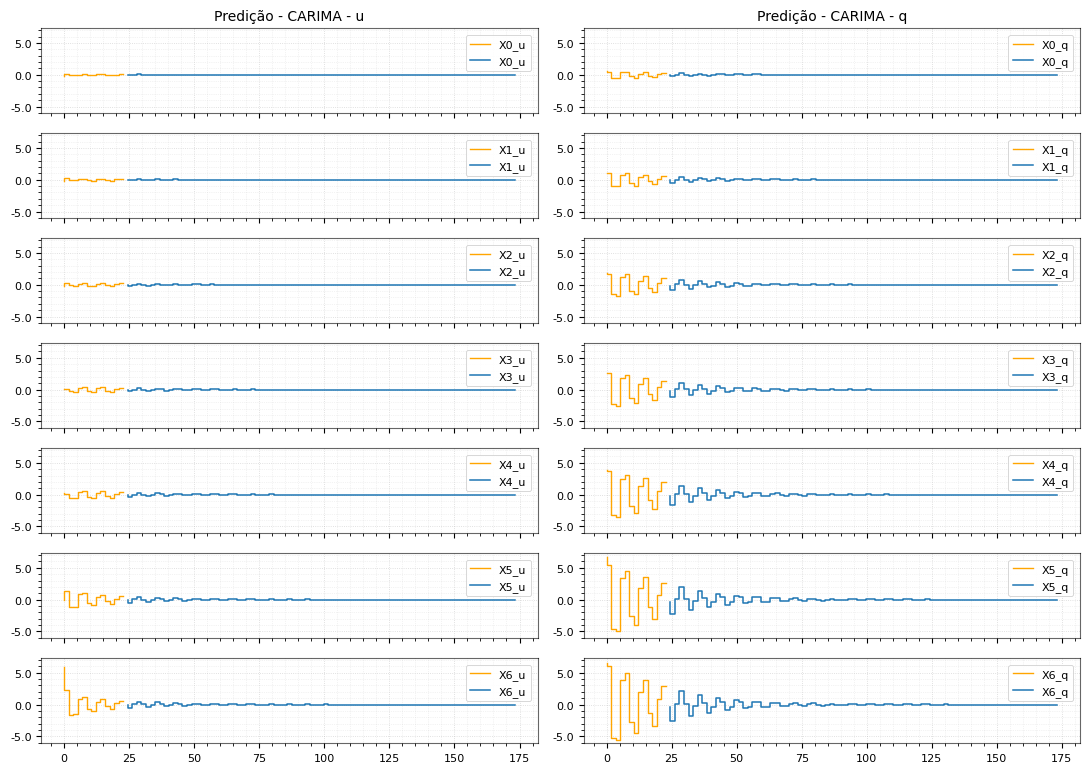

In [46]:
y_pred = [[] for _ in range(H.rows)]
y_pass = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        F = get_F(H_z_matriz[i][j], len(time))
        # pegar a condição inicial 
        y_in = y_matriz_out[i][j][0][1:F.shape[1]+1][::-1]

        # calcula a resposta livre
        y_out = F @ y_in

        # salva pra plotar
        y_plot0 = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_plot1 = [y_in[::-1], "X{}_{}".format(i, cols_name[j]), 'orange', None]
        y_pred[i].append(y_plot0)
        y_pass[i].append(y_plot1)

# plot 
plot(time, y_pred, "Predição - CARIMA", cols_name, time_aux=time, y_matriz_aux=y_pass)

---
* ### função custo minizando apenas xn (nacele)
---

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_11168\2297086692.py:111: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


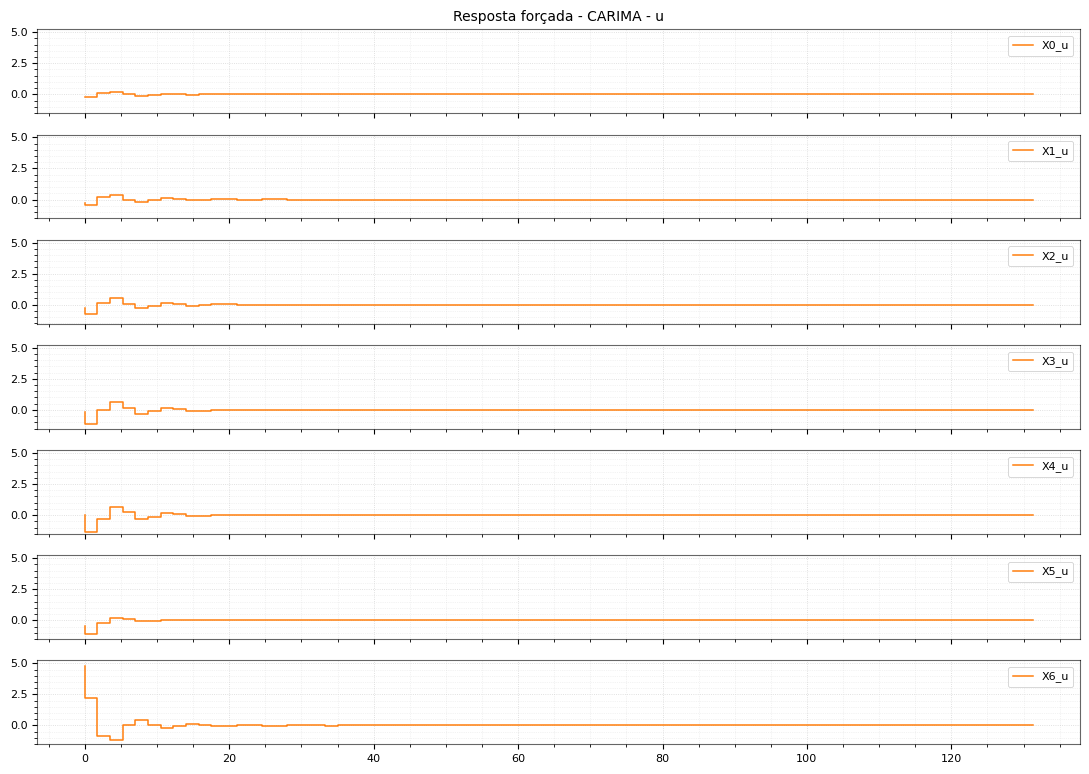

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_11168\3565055036.py:76: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


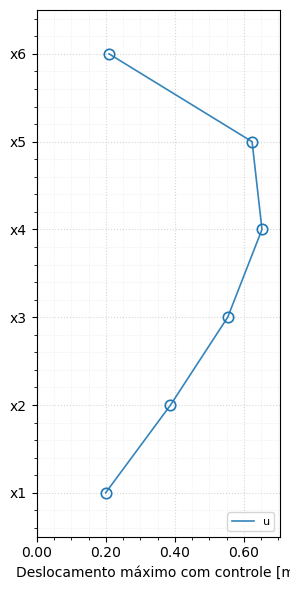

In [82]:
# ponderação nas ações de controle
alpha = 5.0
N_y = len(time)
N_u = len(time)

R = np.eye(N_u) * alpha
Q = np.eye(N_u) # monovariavel - delta é fixo = 1

F, G = generate_matrices(H_z_matriz[n_node-1][0], N_u, N_y)

# solution of quadratic problem
K = np.linalg.inv(G.T @ G + R) @ G.T

# solucao do sistema (free para a massa da nacele)
x0_free = y_pred[n_node-1][1][0].copy()
u_opt = -K @ x0_free

# calcula a resposta forçada para todos os x 
y_controled = [[] for _ in range(H.rows)]

for i in range(H.rows):
        j = 0
        H_ij = H_z_matriz[i][j]
        y_free = y_pred[i][1][0]
        F_ij, G_ij = generate_matrices(H_ij, N_u, N_y)
        y_forced = G_ij @ u_opt
        y_total = y_free + y_forced
        y_plot1 = [y_total[:-10], "X{}_{}".format(i, cols_name[j]), 'C1', None]
        y_controled[i].append(y_plot1)

# plot
plot(time[:-10], y_controled, "Resposta forçada - CARIMA", cols_name)
plot_ladder_uq(time[:-10], y_controled[:-1], col_name=cols_name, x_label="Deslocamento máximo com controle [m]")

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_11168\3565055036.py:76: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


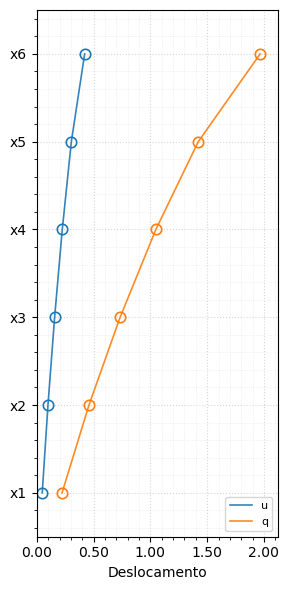

In [81]:
plot_ladder_uq(time, y_pred[:-1])

In [49]:
plot_ladder_uq_gif(time, y_matriz_out[:-1])

Animação salva como 'ladder_uq.gif'.


---
* ### funcao custo minimizando todos os x
---